# dominating set

Set up calculations and store in EspressoDB

In [1]:
import matplotlib.pylab as plt
import seaborn as sns
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"
import numpy as np
import pandas as pd

from qlp.mds import graph_tools as gt
from qlp.mds.qubo import get_mds_qubo
from qlp.mds.solver import classical_search
from qlp.mds.mds_qlpdb import graph_summary, experiment_summary, data_summary, insert_result, QUBO_to_Ising, embed_with_offset

import networkx as nx
from networkx import Graph
from networkx.drawing.nx_pylab import draw
from networkx.algorithms.approximation import min_weighted_dominating_set
from networkx.algorithms.dominating import dominating_set

from dwave.system.samplers import DWaveSampler

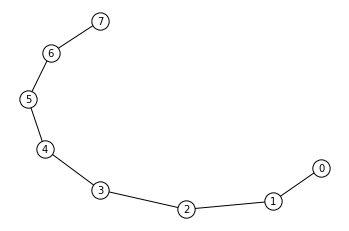

{'tag': 'NN(8)', 'total_vertices': 8, 'total_edges': 7, 'max_edges': 2, 'adjacency': [[0, 1], [1, 2], [6, 7], [4, 5], [5, 6], [2, 3], [3, 4]], 'adjacency_hash': '288514f57e775c5a3f5ee473dae9df3f'}
Greedy solution
 {0, 2, 4, 6}
Chain strength: 4.0
Solving 1/25{0: [1044, 1042], 1: [1054, 1046], 2: [1053, 1051, 1045, 923], 3: [924, 920, 932, 1048], 4: [934, 928, 800, 926], 5: [933, 930, 941, 802], 6: [937, 942, 809], 7: [943, 936], 8: [1041], 9: [1043], 10: [1047, 1040], 11: [1055, 1049], 12: [1052, 1050], 13: [925, 922], 14: [921, 927], 15: [931], 16: [935, 929], 17: [801, 805, 813], 18: [814, 806], 19: [939], 20: [938, 940], 21: [808, 812]}
Solving 2/25{0: [57, 60], 1: [56, 184, 63], 2: [186, 58, 314], 3: [188, 196, 187, 315], 4: [319, 327, 313], 5: [323, 195, 326, 451], 6: [321, 449, 325], 7: [457, 463, 455], 8: [59], 9: [70, 62], 10: [61, 65, 69], 11: [189, 185], 12: [191], 13: [318], 14: [317, 312], 15: [322, 194], 16: [316, 324], 17: [448, 320], 18: [453, 441, 445], 19: [462, 454], 

In [ ]:
# Define Adjacency matrix
# Hamming(d,q)
# Biparti
# NN(v): 1D nearest neighbor with v vertices. max is 16 before minor embedding starts breaking
#graph, tag = gt.generate_hamming_graph(1, 2)
#graph, tag = gt.generate_bipartite_graph(3, 3)
#graph, tag = gt.generate_newman_watts_strogatz_graph(10, 4, 0.1)
# graph, tag = gt.generate_corona_graph(3,6)
for nvertices in range(8,9):
    graph, tag = gt.generate_nn_graph(nvertices)
    penalty = 2

    directed = False
    qubo = get_mds_qubo(graph, directed=directed, penalty = penalty, triangularize=True, dtype="d")
    q_min = np.array(list(qubo.values())).min()

    gt.get_plot(graph, directed=directed)
    plt.show()
    graph_params = graph_summary(tag, graph)
    print(graph_params)

    G = nx.Graph()
    G.add_edges_from(graph)
    print("Greedy solution\n", dominating_set(G))
    
    # Experiment
    J, h, C = QUBO_to_Ising(qubo.todense().tolist())
    maxJ = max(abs(J).flatten())
    maxh = max(abs(h))
    #print("Initial")
    #print(f"max(J) = {maxJ}")
    #print(f"max(h) = {maxh}")
    #print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
    #print("Must scale QUBO to these ranges\n")
    fact = 1 #max([maxJ, maxh/2]) * 1.2
    qubo = qubo / fact

    J, h, C = QUBO_to_Ising(qubo.todense().tolist())
    maxJ = max(abs(J).flatten())
    maxh = max(abs(h))
    #print("Rescaled")
    #print(f"max(J) = {maxJ}")
    #print(f"max(h) = {maxh}")
    #print("DWave J_range = [-1.0, 1.0] \nDWave h_range = [-2.0, 2.0]")
    #print("Must scale QUBO to these ranges\n")

    # Set chain strength
    chain_strength = maxJ*2
    print(f"Chain strength: {chain_strength}")
    
    # DWave settings
    solver = "DW_2000Q_5"
    sampler = DWaveSampler(solver=solver)
    
    # Set offset percentage
    # set percentage to 0 for no offset
    percentage = 0.05
    
    iterations = 25
    for idx in range(iterations):
        print(f"\rSolving {idx+1}/{iterations}", end="")
        qubo_dict, embed, anneal_offsets = embed_with_offset(sampler=sampler, qubo=qubo, percentage=percentage, offset=True)

        dwave_config = {
            "annealing_time": 500,  # integer microseconds [1, 2000]
            "answer_mode": "raw", # histogram or raw
            "auto_scale": True,
            "num_reads": 1000,  # raw will dump out all results
            "num_spin_reversal_transforms": 0,
            "readout_thermalization": 0, # default 0
            "programming_thermalization": 1000, # default 1000
            "chain_strength": chain_strength,
            "anneal_offsets": anneal_offsets
        }
        solver = "DW_2000Q_5"

        experiment_params = experiment_summary(machine=solver, settings=dwave_config, penalty=penalty, factor=fact, chain_strength=chain_strength, percentage=percentage, qubo=qubo)

        # Solve on DWave and push to database
        result = embed.sample_qubo(qubo_dict, **dwave_config)
        raw = result.to_pandas_dataframe()
        data_params = data_summary(raw, graph_params, experiment_params)
        result = insert_result(graph_params, experiment_params, data_params)
print("\nDONE")

In [ ]:
graph, _ = gt.generate_nn_graph(3)
print(graph)
G = nx.Graph()
G.add_edges_from(graph)
draw(G)

In [ ]:
len([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313,314,315,316,317,318,319,320])